First we load the dataset

In [140]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

import matplotlib.pyplot as plt

df = pd.read_csv("Train.csv")

We now check the basic details about the dataset

In [141]:
print(df.shape)
print(df.info())
print(df.isnull().sum())

(8523, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 8523 non-null   int64  
 1   Item_Identifier            8523 non-null   object 
 2   Item_Weight                8523 non-null   float64
 3   Item_Fat_Content           8523 non-null   object 
 4   Item_Visibility            8523 non-null   float64
 5   Item_Type                  8523 non-null   object 
 6   Item_MRP                   8523 non-null   float64
 7   Outlet_Identifier          8523 non-null   object 
 8   Outlet_Establishment_Year  8523 non-null   int64  
 9   Outlet_Size                6113 non-null   object 
 10  Outlet_Location_Type       8523 non-null   object 
 11  Outlet_Type                8523 non-null   object 
 12  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(2), object(7)
me

As we can observe Item_Weight and Outlet_Size have some none value so we will fill them with mode and median respectively

In [142]:
df['Outlet_Size'].fillna(df['Outlet_Size'].mode(), inplace=True)
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)

# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

Unnamed: 0                      0
Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


Now we will try to look for outliers

In [143]:
# Check for outliers
for column in df.columns:
    # Get the interquartile range (IQR)
    iqr = df[column].describe().get('iqr')

    if iqr is not None:
        # Get the lower and upper Tukey fences
        lower_fence = df[column].describe().mean() - 1.5 * iqr
        upper_fence = df[column].describe().mean() + 1.5 * iqr

        # Identify outliers
        outliers = df[column][df[column] < lower_fence]
        outliers = outliers.append(df[column][df[column] > upper_fence])

        print(f"Outliers for column {column}: {outliers}")
    else:
        print(f"No outliers found for column {column}")


No outliers found for column Unnamed: 0
No outliers found for column Item_Identifier
No outliers found for column Item_Weight
No outliers found for column Item_Fat_Content
No outliers found for column Item_Visibility
No outliers found for column Item_Type
No outliers found for column Item_MRP
No outliers found for column Outlet_Identifier
No outliers found for column Outlet_Establishment_Year
No outliers found for column Outlet_Size
No outliers found for column Outlet_Location_Type
No outliers found for column Outlet_Type
No outliers found for column Item_Outlet_Sales


Now we will do encoding

In [144]:
df['Item_Type_New'] = df['Item_Type'].replace({'Dairy': 'Food', 'Frozen': 'Food', 'Fruits and Vegetables': 'Food', 'Household': 'Non-Food', 'Meat': 'Food', 'Others': 'Non-Food', 'Snacks': 'Food'})
encoder = LabelEncoder()
df['Item_Type_New'] = encoder.fit_transform(df['Item_Type_New'])
df['Outlet_Type'] = encoder.fit_transform(df['Outlet_Type'])
df['Outlet_Size'] = encoder.fit_transform(df['Outlet_Size'])
df['Outlet_Location_Type'] = encoder.fit_transform(df['Outlet_Location_Type'])
df['Item_Fat_Content'] = encoder.fit_transform(df['Item_Fat_Content'])
df['Outlet_Identifier'] = encoder.fit_transform(df['Outlet_Identifier'])

Now we'll see how individual columns is distributed and then we'll scale them accordingly.

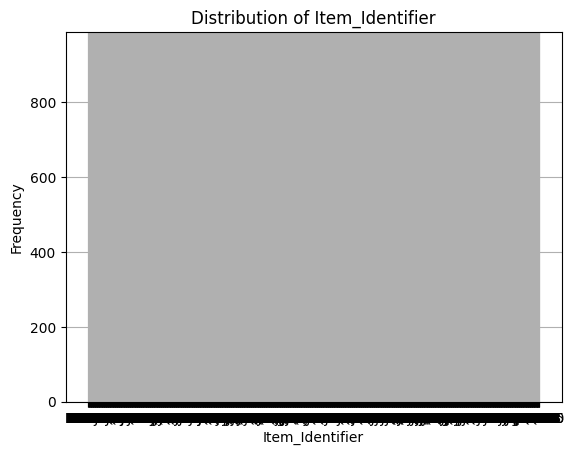

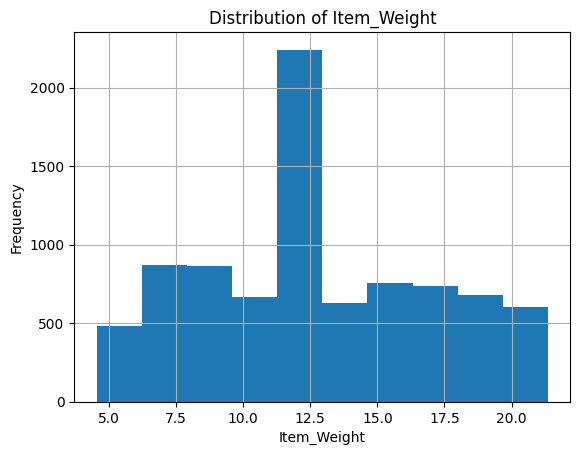

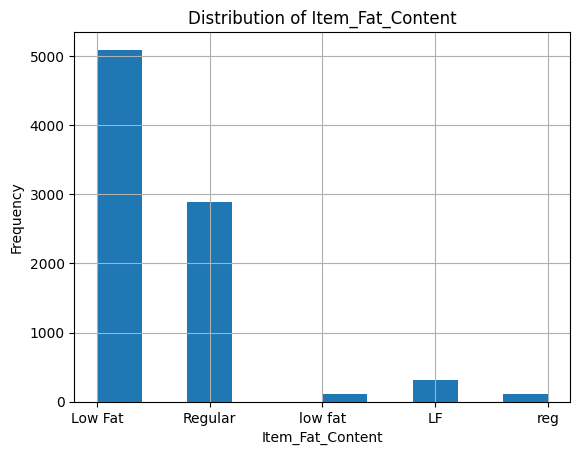

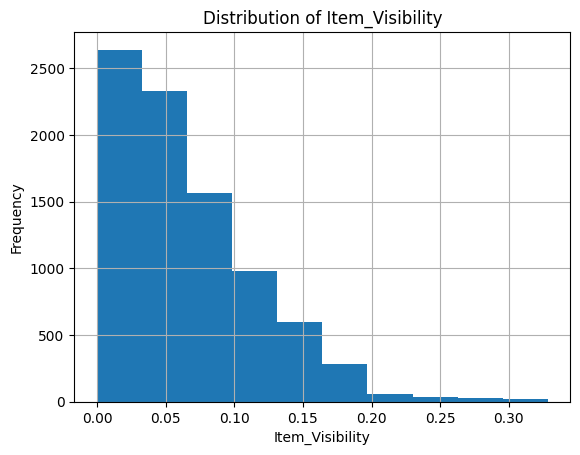

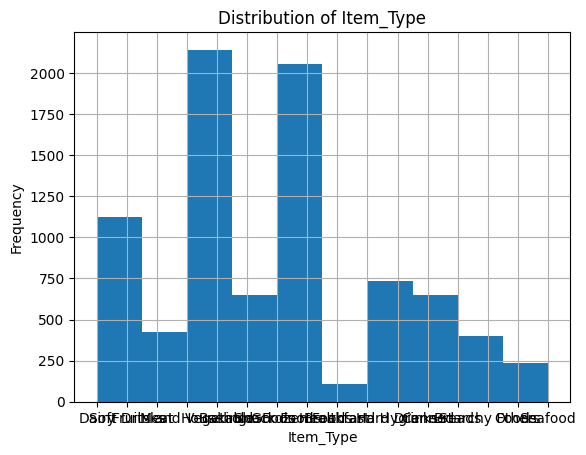

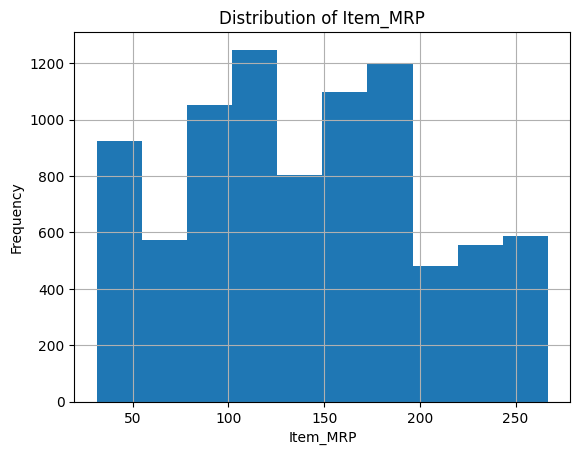

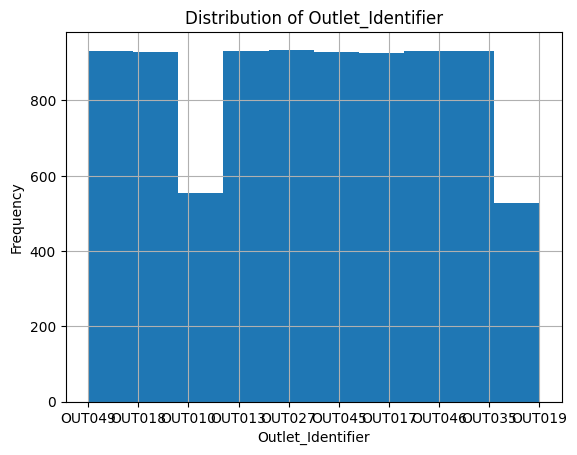

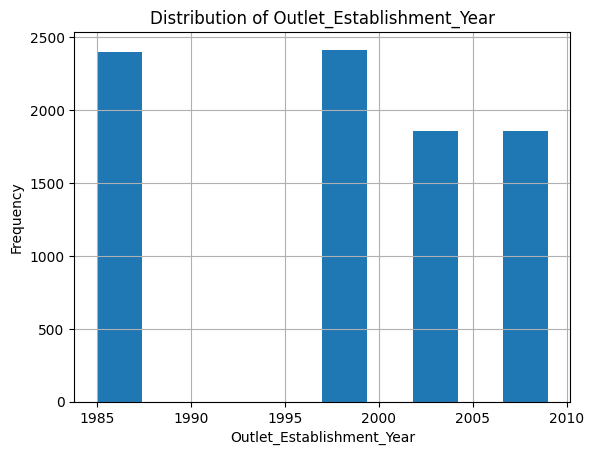

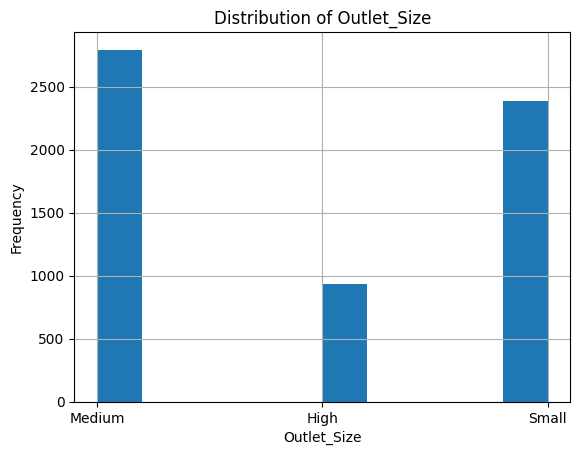

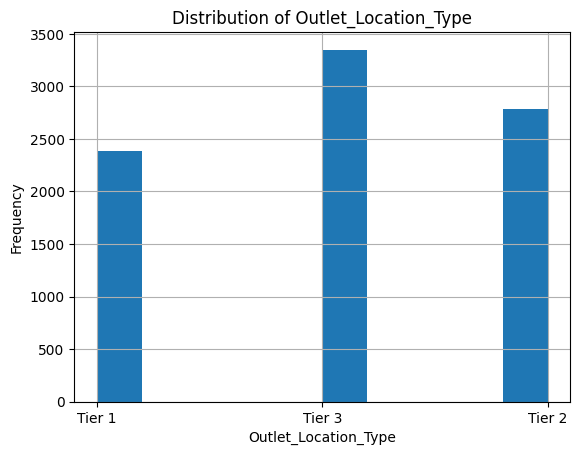

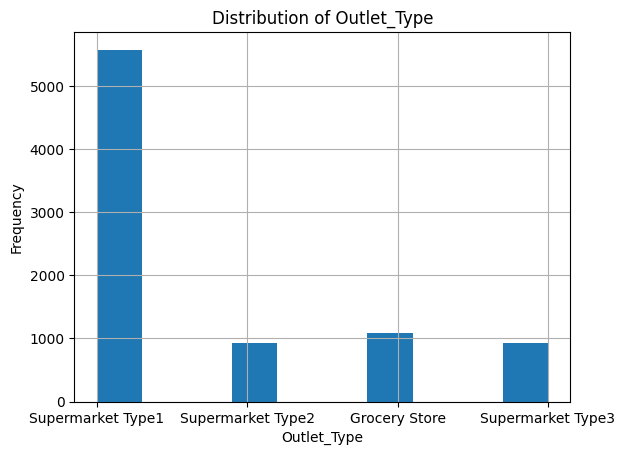

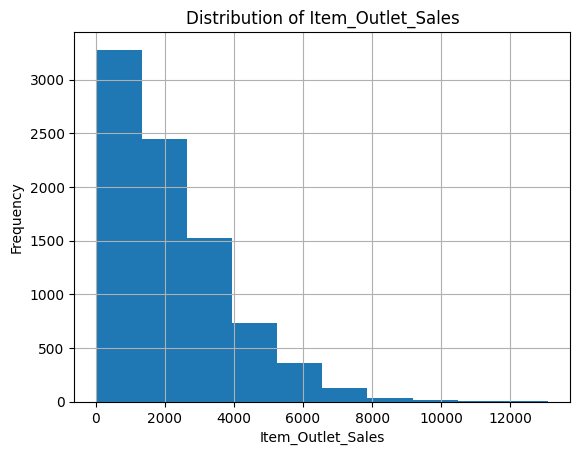

In [135]:
for column in df.columns:
    # Plot a histogram of the column
    df[column].hist()

    # Add a title to the plot
    title = f"Distribution of {column}"
    plt.title(title)

    # Add labels to the x-axis and y-axis
    plt.xlabel(column)
    plt.ylabel("Frequency")

    # Show the plot
    plt.show()

We are now gonna check the correlation between the columns , this will help us reduce the number of features.

<ipython-input-136-ba1f4cd6abff>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
<ipython-input-136-ba1f4cd6abff>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt= '.2f')


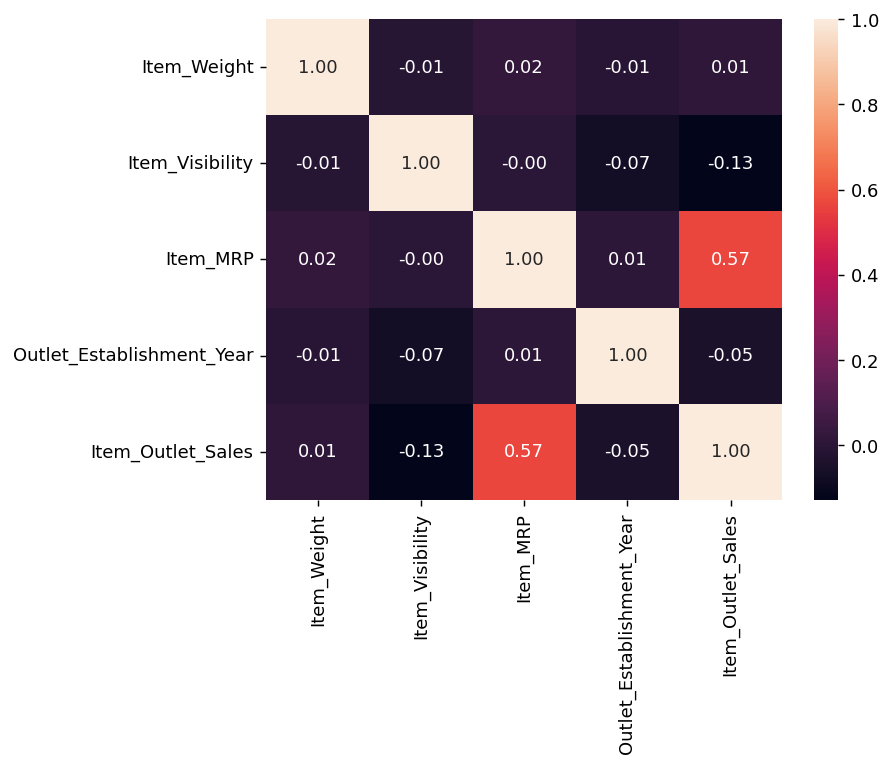

In [136]:
#correlation
corr = df.corr()

plt.figure(dpi=130)
sns.heatmap(df.corr(), annot=True, fmt= '.2f')
plt.show()

Scaling few columns

In [137]:

# Create a list of columns to scale
cols_to_scale = ["Item_MRP", "Item_Weight", "Item_Visibility"]

# Standardize the columns
for col in cols_to_scale:
  mean = df[col].mean()
  std = df[col].std()
  df[col] = (df[col] - mean) / std

# Save the scaled dataset
df.to_csv("Train.csv")


Regularised Linear Regression Model

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

# Drop the "Item_Identifier" column
df = df.drop("Item_Type", axis=1)
df = df.drop("Item_Identifier", axis=1)

nan_rows = df[df.isnull().any(axis=1)]

# If there are any NaN values, drop them
if len(nan_rows) > 0:
    df = df.dropna(axis=0)


# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df, df["Item_Outlet_Sales"], test_size=0.25)

# Create a regularized linear regression model
reg = Ridge(alpha=0.1)

# Fit the model to the training data
reg.fit(X_train, y_train)

# Predict the test set
y_pred = reg.predict(X_test)

# Calculate the mean squared error
mse = np.mean((y_pred - y_test)**2)

print("Mean squared error:", mse)


Mean squared error: 1.6138894226116251e-16


Linear Regression Model

In [146]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df, df["Item_Outlet_Sales"], test_size=0.25)

# Create a linear regression model
reg = LinearRegression()

# Fit the model to the training data
reg.fit(X_train, y_train)

# Predict the test set
y_pred = reg.predict(X_test)

# Calculate the mean squared error
mse = np.mean((y_pred - y_test)**2)

print("Mean squared error:", mse)


Mean squared error: 4.208498581712519e-25


Random Forest Regressor

In [147]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df, df["Item_Outlet_Sales"], test_size=0.25)

# Create a linear regression model
reg = RandomForestRegressor(n_estimators=100, max_depth=5)

# Fit the model to the training data
reg.fit(X_train, y_train)

# Predict the test set
y_pred = reg.predict(X_test)

# Calculate the mean squared error
mse = np.mean((y_pred - y_test)**2)

print("Mean squared error:", mse)


Mean squared error: 3054.3728762087135


XGBoost

In [148]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor


# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df, df["Item_Outlet_Sales"], test_size=0.25)

# Create a linear regression model
reg = XGBRegressor(n_estimators=100, max_depth=5)

# Fit the model to the training data
reg.fit(X_train, y_train)

# Predict the test set
y_pred = reg.predict(X_test)

# Calculate the mean squared error
mse = np.mean((y_pred - y_test)**2)

print("Mean squared error:", mse)


Mean squared error: 129.4355311653715


# Summary
So we can observe that the Linear regression model is the best model to predict the sales as it is almost 100% accurate.